In [1]:
import torch
import torchvision as torchvision
from torchvision import models,datasets,transforms
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
params = { 'batch_size':10,
           'shuffle':True,
           'num_workers':8 }

In [3]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(256), #Augmented
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = '/content/drive/MyDrive/DataSet'

In [9]:
train_dataset = datasets.ImageFolder(os.path.join(path,"Train"),transform = transform )

In [10]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [12]:
test_dataset = datasets.ImageFolder(os.path.join(path, 'Test'),transform = transform )

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, **params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

In [15]:
class_names = train_dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
print('DataSet description\n')
print('Train dataset = {}\n'.format(len(train_dataset)))
print('Test dataset = {}\n'.format(len(test_dataset)))
print('Classes = {}'.format(class_names))

DataSet description

Train dataset = 200

Test dataset = 200

Classes = ['Fake', 'Live']


In [17]:
def train(model, loss_fn, optimizer, num_epochs=25):

    best_acc = 0

    for epoch in range(num_epochs):
        
        print('Epoch {}'.format(epoch+1))
        
        # Train dataset
        model.train()
        train_loss = 0.0
        train_correct = 0
        size = len(train_dataset)
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(preds == labels.data)
            
        train_loss = train_loss / size
        train_acc = train_correct.double() / size
            
        print('Training Loss: {} Acc: {}'.format(train_loss, train_acc))
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        size = len(test_dataset)
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += torch.sum(preds == labels.data) 

        val_loss = val_loss / size
        val_acc = val_correct.double() / size    

        print('Validation Loss: {} Acc: {}'.format(val_loss, val_acc))    
            
        if val_acc > best_acc:
            best_acc = val_acc

    print('Best val Acc: {}'.format(best_acc))

    return model

In [18]:
net = torchvision.models.densenet121(pretrained=True)
for param in net.parameters():
    param.requires_grad = False 

ft = net.classifier.in_features 
net.classifier = nn.Linear(ft, 5)

net = net.to(device)

loss = nn.CrossEntropyLoss()


optimizer = optim.SGD(net.classifier.parameters(), lr=0.001, momentum=0.9) 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [19]:
net = train(net,loss,optimizer,num_epochs=10)

Epoch 1
Training Loss: 0.7756725624203682 Acc: 0.68
Validation Loss: 0.5454037085175514 Acc: 0.795
Epoch 2
Training Loss: 0.3347220219671726 Acc: 0.895
Validation Loss: 0.50522990077734 Acc: 0.765
Epoch 3
Training Loss: 0.2544234339147806 Acc: 0.91
Validation Loss: 0.5507237665355206 Acc: 0.685
Epoch 4
Training Loss: 0.1851126689463854 Acc: 0.94
Validation Loss: 0.40250817984342574 Acc: 0.82
Epoch 5
Training Loss: 0.21129662469029425 Acc: 0.92
Validation Loss: 0.5659294322133064 Acc: 0.69
Epoch 6
Training Loss: 0.2558947540819645 Acc: 0.895
Validation Loss: 0.40580244958400724 Acc: 0.805
Epoch 7
Training Loss: 0.16592646781355141 Acc: 0.94
Validation Loss: 0.3966567777097225 Acc: 0.82
Epoch 8
Training Loss: 0.12768449429422618 Acc: 0.965
Validation Loss: 0.47947085872292516 Acc: 0.73
Epoch 9
Training Loss: 0.1872871325351298 Acc: 0.92
Validation Loss: 0.37677733674645425 Acc: 0.855
Epoch 10
Training Loss: 0.20780427437275648 Acc: 0.92
Validation Loss: 0.36695965230464933 Acc: 0.86
Best

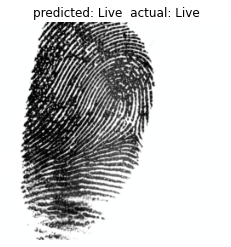

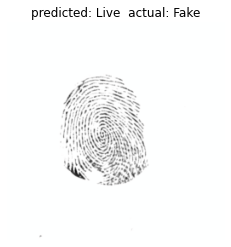

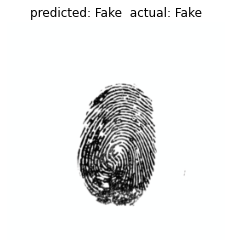

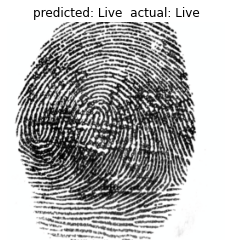

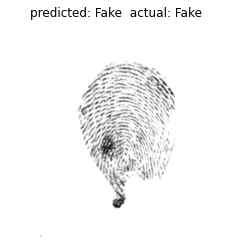

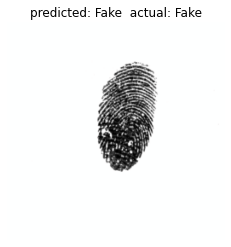

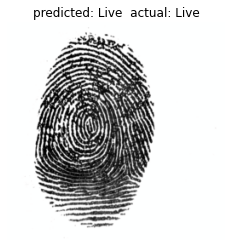

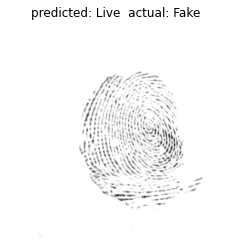

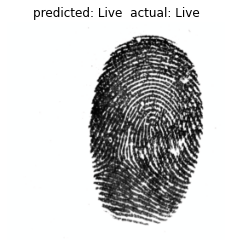

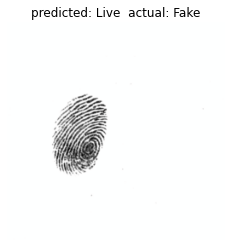

In [20]:
net.eval()

fig = plt.figure()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for j in range(10):
            ax = plt.subplot(1, 1, 1)
            ax.axis('off')
            ax.set_title('predicted: {}  actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
            imshow(inputs.cpu().data[j])
        break